# REMEMBER TO FUCKING NORMALIZE THE FUCKING SHITTY DATA

# Semantic Segmentation: UNET for Self-Driving Cars

Semantic image segmentation is the task of classifying each pixel in an image from a predefined set of classes. In the following example, different entities are classified.

In particular, our goal is to take an image of size W x H x 3 and generate a W x H matrix containing the predicted class ID’s corresponding to all the pixels.

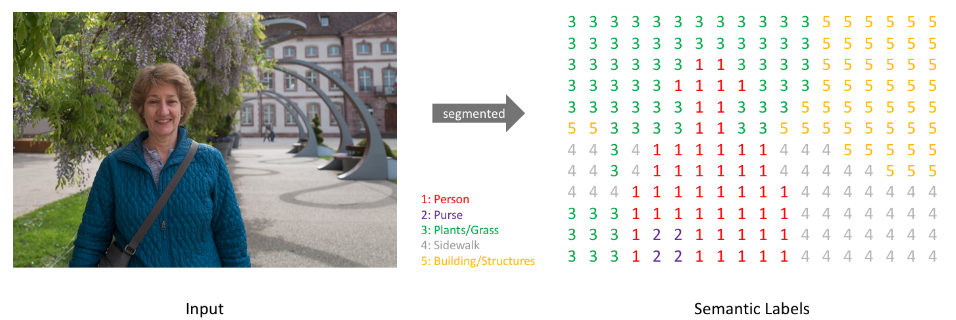

### Import Dependencies

In [17]:
import os
import cv2
import keras
import pandas as pd
import numpy as np
from glob import glob
from tqdm import tqdm 
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from keras.utils import normalize

In [18]:
np.random.seed(2024)
SIZE = 256      # (heigth x width)

In [19]:
classes = pd.read_csv("CamVid\\class_dict.csv", index_col =0)
classes.T

name,Animal,Archway,Bicyclist,Bridge,Building,Car,CartLuggagePram,Child,Column_Pole,Fence,...,SUVPickupTruck,TrafficCone,TrafficLight,Train,Tree,Truck_Bus,Tunnel,VegetationMisc,Void,Wall
r,64,192,0,0,128,64,64,192,192,64,...,64,0,0,192,128,192,64,192,0,64
g,128,0,128,128,0,0,0,128,192,64,...,128,0,64,64,128,128,0,192,0,192
b,64,128,192,64,0,128,192,64,128,128,...,192,64,64,128,0,192,64,0,0,0


In [20]:
cls2rgb = {clas:list(classes.loc[clas, :]) for clas in classes.index}

In [21]:
cls2rgb.keys(), cls2rgb.values()

(dict_keys(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car', 'CartLuggagePram', 'Child', 'Column_Pole', 'Fence', 'LaneMkgsDriv', 'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving', 'ParkingBlock', 'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk', 'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone', 'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel', 'VegetationMisc', 'Void', 'Wall']),
 dict_values([[64, 128, 64], [192, 0, 128], [0, 128, 192], [0, 128, 64], [128, 0, 0], [64, 0, 128], [64, 0, 192], [192, 128, 64], [192, 192, 128], [64, 64, 128], [128, 0, 192], [192, 0, 64], [128, 128, 64], [192, 0, 192], [128, 64, 64], [64, 192, 128], [64, 64, 0], [128, 64, 128], [128, 128, 192], [0, 0, 192], [192, 128, 128], [128, 128, 128], [64, 128, 192], [0, 0, 64], [0, 64, 64], [192, 64, 128], [128, 128, 0], [192, 128, 192], [64, 0, 64], [192, 192, 0], [0, 0, 0], [64, 192, 0]]))

In [22]:
idx2rgb={idx:np.array(rgb) for idx, (cl, rgb) in enumerate(cls2rgb.items())}

In [23]:
idx2rgb.keys(), idx2rgb.values()

(dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]),
 dict_values([array([ 64, 128,  64]), array([192,   0, 128]), array([  0, 128, 192]), array([  0, 128,  64]), array([128,   0,   0]), array([ 64,   0, 128]), array([ 64,   0, 192]), array([192, 128,  64]), array([192, 192, 128]), array([ 64,  64, 128]), array([128,   0, 192]), array([192,   0,  64]), array([128, 128,  64]), array([192,   0, 192]), array([128,  64,  64]), array([ 64, 192, 128]), array([64, 64,  0]), array([128,  64, 128]), array([128, 128, 192]), array([  0,   0, 192]), array([192, 128, 128]), array([128, 128, 128]), array([ 64, 128, 192]), array([ 0,  0, 64]), array([ 0, 64, 64]), array([192,  64, 128]), array([128, 128,   0]), array([192, 128, 192]), array([64,  0, 64]), array([192, 192,   0]), array([0, 0, 0]), array([ 64, 192,   0])]))

### Functions

In [24]:
def load_images(paths, size=SIZE):
    img_list = []

    for image_path in paths:
        img = cv2.imread(image_path)                                        # 0 to convert to grayscale (should ontain an array (n, h, w, 1) <=> (n, h, w))
        img = cv2.cvtColor((img).astype(np.uint8), cv2.COLOR_BGR2RGB)       # If you want to get the same order as in the color mapping of CAMVID, use the cv converted
        img = cv2.resize(img, (SIZE, SIZE))                                 # with default interpolation = bilinear
        img_list.append(img)
    
    return np.array(img_list)



def show_pairs(images, masks, cmap=None):
    if images.shape[0] != masks.shape[0]:
        raise ValueError("Number of images must be equal to the number of masks.")
    
    if len(images.shape) != 4:      # means that it's a single pair of images to be plotted
        plt.subplot(1,2,1)
        plt.imshow(images)
        plt.subplot(1,2,2)
        plt.imshow(masks)
    
    else:
        n = images.shape[0]
        fig, axs = plt.subplots(nrows=n, ncols=2, figsize=(8,3*n))
        for i in range(n):
            axs[i, 0].imshow(images[i])
            axs[i, 1].imshow(masks[i], cmap=cmap)
        plt.tight_layout()



def adjust_mask(mask, flat=False):
    
    semantic_map = []
    for colour in list(cls2rgb.values()):        
        equality = np.equal(mask, colour)               # 256x256x3 with True or False
        class_map = np.all(equality, axis = -1)         # 256x256 If all True, then True, else False
        semantic_map.append(class_map)                  # List of 256x256 arrays, map of True for a given found color at the pixel, and False otherwise.
    semantic_map = np.stack(semantic_map, axis=-1)      # 256x256x32 True only at the found color, and all False otherwise.
    if flat:
      semantic_map = np.reshape(semantic_map, (-1,256*256))

    return np.float32(semantic_map)                     # convert to numbers


# Map the idx back to rgb
def map_class_to_rgb(p):
  return idx2rgb[p[0]]

# rgb_mask = np.apply_along_axis(map_class_to_rgb, -1, np.expand_dims(np.argmax(new_mask, axis=-1), -1))

With these last 2 functions we "encode" the "revert" the mask's RGB channel into a an encoded mask. In simple terms:
- new_mask = adjust_mask(mask) -> this new_mask will have shape (256, 256, 32) where 32 is the number of channels of the image each representing one of the classes
- rgb_mask = np.apply_along_axis(map_class_to_rgb, -1, np.expand_dims(np.argmax(new_mask, axis=-1), -1)) -> rgb_mask will be the reverted mask turning into shape (256, 256, 3). rgb_mask is basically the same exact thing as the mask given in input to the adjust_mask function

### Data Loading

In [25]:
root_path = 'CamVid'

train_image_paths = sorted(glob(os.path.join(root_path, 'train/*')))
train_mask_paths = sorted(glob(os.path.join(root_path, 'train_labels/*')))

val_image_paths = sorted(glob(os.path.join(root_path, 'val/*')))
val_mask_paths = sorted(glob(os.path.join(root_path, 'val_labels/*')))

test_image_paths = sorted(glob(os.path.join(root_path, 'test/*')))
test_mask_paths = sorted(glob(os.path.join(root_path, 'test_labels/*')))

In [26]:
# load data
train_images = load_images(train_image_paths)
train_masks = load_images(train_mask_paths)

In [27]:
val_images = load_images(val_image_paths)
val_masks = load_images(val_mask_paths)

In [28]:
test_images = load_images(test_image_paths)
test_masks = load_images(test_mask_paths)

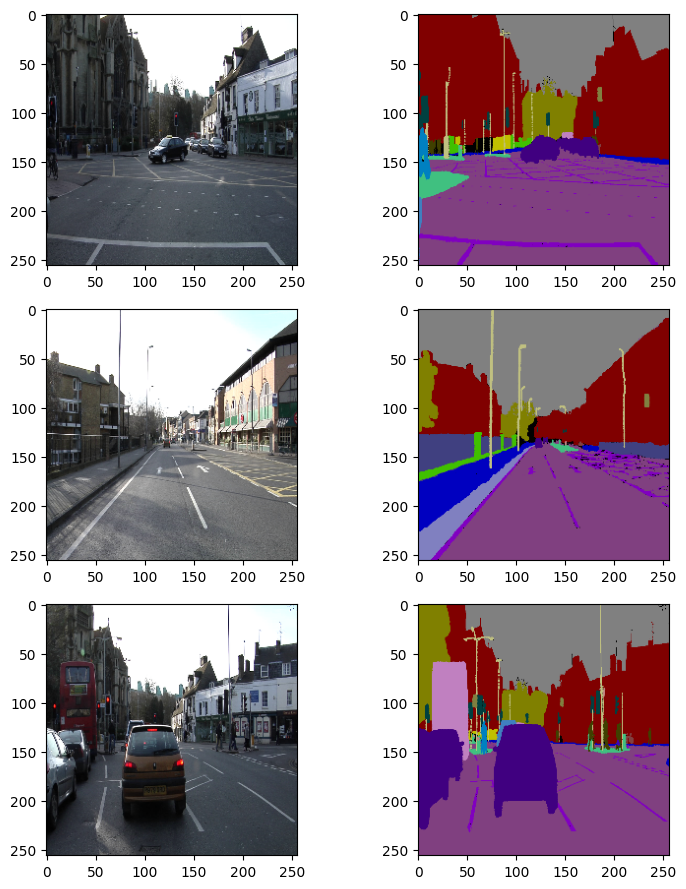

In [29]:
idx = np.random.randint(train_images.shape[0], size=3)
show_pairs(train_images[idx], train_masks[idx])

### Encoding Mask Labels

In [30]:
train_masks_encoded = adjust_mask(train_masks)

In [31]:
train_masks_encoded.shape

(369, 256, 256, 32)

In [37]:
np.unique(train_masks_encoded)

array([0., 1.], dtype=float32)

In [39]:
train_images = normalize(train_images, axis=1)

In [42]:
from Models import multi_unet_model

In [43]:
IMG_HEIGHT = train_images.shape[1]
IMG_WIDTH  = train_images.shape[2]
IMG_CHANNELS = train_images.shape[3]

def get_model():
    return multi_unet_model(n_classes=32, IMG_HEIGHT=IMG_HEIGHT, IMG_WIDTH=IMG_WIDTH, IMG_CHANNELS=IMG_CHANNELS)

model = get_model()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 dropout (Dropout)              (None, 256, 256, 16  0           ['conv2d[0][0]']                 
                                )                                                             

In [45]:
history = model.fit(train_images, train_masks_encoded, 
                    batch_size = 16, 
                    verbose=1, 
                    epochs=3)

Epoch 1/3
24/24 [==============================] - 106s 4s/step - loss: 2.9312 - accuracy: 0.1987
Epoch 2/3
24/24 [==============================] - 100s 4s/step - loss: 2.3884 - accuracy: 0.2700
Epoch 3/3
24/24 [==============================] - 98s 4s/step - loss: 1.9686 - accuracy: 0.3696
